In [1]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from collections import namedtuple, deque
from google.colab import drive
import networkx as nx
from collections import defaultdict
drive.mount('/content/drive')

Mounted at /content/drive


# Env

In [2]:
class FourRoomEnv(gym.Env):
    """
    Custom FourRoom environment with fixed start in upper-left room and goal in bottom-right room.
    Each room is 5x5, total grid 11x11 with walls separating rooms and hallways (gaps) connecting them.
    Reward: +1 only when reaching the goal, 0 otherwise.
    """
    def __init__(self):
        self.grid_size = 11
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Discrete(self.grid_size ** 2)
        self.start_pos = (0, 0)  # Upper-left room
        self.goal_pos = (10, 10)  # Bottom-right room
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right

        # Define walls (impassable positions)
        self.walls = set()
        # Add all positions in row 5 as potential walls
        for c in range(self.grid_size):
            self.walls.add((5, c))
        # Add all positions in column 5 as potential walls
        for r in range(self.grid_size):
            self.walls.add((r, 5))

        # Remove the gap positions from the walls
        self.walls.remove((2, 5)) # Vertical gap top
        self.walls.remove((8, 5)) # Vertical gap bottom
        self.walls.remove((5, 2)) # Horizontal gap left
        self.walls.remove((5, 8)) # Horizontal gap right

        # Build graph for optimal policy (using networkx)
        self.positions = [(r, c) for r in range(self.grid_size) for c in range(self.grid_size) if (r, c) not in self.walls]
        self.G = nx.Graph()
        for pos in self.positions:
            self.G.add_node(pos)
        for pos in self.positions:
            r, c = pos
            for dr, dc in self.actions:
                nr, nc = r + dr, c + dc
                if (nr, nc) in self.positions:
                    self.G.add_edge(pos, (nr, nc))

        # Compute shortest path distances to goal
        self.dist_to_goal = nx.shortest_path_length(self.G, target=self.goal_pos)

        # Precompute optimal actions for each position
        self.optimal_actions = defaultdict(list)
        for pos in self.positions:
            if pos == self.goal_pos:
                continue
            # Ensure pos is in dist_to_goal before accessing (should be true if graph is connected)
            if pos in self.dist_to_goal:
                dist = self.dist_to_goal[pos]
                for a_idx, (dr, dc) in enumerate(self.actions):
                    nr, nc = pos[0] + dr, pos[1] + dc
                    if (nr, nc) in self.positions and self.dist_to_goal.get((nr, nc), float('inf')) == dist - 1:
                        self.optimal_actions[pos].append(a_idx)

        self.reset()

    def reset(self, *, seed=None, options=None):
        self.current_pos = self.start_pos
        return self.pos_to_state(self.current_pos), {}

    def pos_to_state(self, pos):
        return pos[0] * self.grid_size + pos[1]

    def state_to_pos(self, state):
        return divmod(state, self.grid_size)

    def step(self, action):
        row, col = self.current_pos
        dr, dc = self.actions[action]
        new_row, new_col = row + dr, col + dc
        if 0 <= new_row < self.grid_size and 0 <= new_col < self.grid_size and (new_row, new_col) not in self.walls:
            self.current_pos = (new_row, new_col)
        terminated = self.current_pos == self.goal_pos
        reward = 1 if terminated else 0
        truncated = False  # No time limit
        return self.pos_to_state(self.current_pos), reward, terminated, truncated, {}

    def get_action(self, pos, epsilon=0.3):
        """
        Epsilon-greedy policy based on optimal actions.
        With prob epsilon, random action; else, random optimal action.
        """
        if random.random() < epsilon or not self.optimal_actions[pos]:
            return random.randint(0, 3)
        return random.choice(self.optimal_actions[pos])

# Load Dataset

In [3]:
filename = f"drive/MyDrive/Colab Notebooks/LLMAgent/FourRoom/Datasets/FourRoom-Low.pkl"

In [4]:
with open(filename, "rb") as f:
  dataset = pickle.load(f)
print(f"Loaded {len(dataset)} trajectories from {filename}")

Loaded 1000 trajectories from drive/MyDrive/Colab Notebooks/LLMAgent/FourRoom/Datasets/FourRoom-Low.pkl


In [5]:
max_steps = 100

# HyperParameters

In [6]:
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# IQL Agent

In [15]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        return Transition(*zip(*transitions))

    def __len__(self):
        return len(self.buffer)

In [16]:
# Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [17]:
# Value Network
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [18]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # logits

In [19]:
class IQL:
    def __init__(self, state_dim, action_dim, lr=3e-4, expectile=0.8, beta=3.0,  tau=0.005):
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.q_target = QNetwork(state_dim, action_dim).to(device)
        self.q_target.load_state_dict(self.q_network.state_dict())
        self.value_network = ValueNetwork(state_dim).to(device)
        self.policy_network = PolicyNetwork(state_dim, action_dim).to(device)

        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=lr)
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)

        self.expectile = expectile
        self.beta = beta
        self.action_dim = action_dim
        self.tau = tau

    def expectile_loss(self, diff):
        weight = torch.where(diff > 0, self.expectile, 1 - self.expectile)
        return weight * diff**2

    def soft_update_target(self):
        for param, target_param in zip(self.q_network.parameters(), self.q_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def update(self, batch, gamma=0.99):
        state = torch.FloatTensor(batch.state).to(device)
        action = torch.LongTensor(batch.action).to(device)
        next_state = torch.FloatTensor(batch.next_state).to(device)
        reward = torch.FloatTensor(batch.reward).to(device)
        done = torch.FloatTensor(batch.done).to(device)


        #print(state.shape, action.unsqueeze(1).shape)
        #print(self.q_target(state).shape)
        # Value function update
        with torch.no_grad():
            q_values = self.q_target(state).gather(1, action.unsqueeze(1)).squeeze(1)
        v_values = self.value_network(state).squeeze()
        value_loss = self.expectile_loss(q_values - v_values).mean()

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        # Q-function update
        with torch.no_grad():
            next_v = self.value_network(next_state).squeeze()
            target_q = reward + gamma * (1 - done) * next_v

        current_q = self.q_network(state).gather(1, action.unsqueeze(1)).squeeze()
        q_loss = F.mse_loss(current_q, target_q)

        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # Update Target Q
        self.soft_update_target()

        # Policy update with advantage-weighted behavior cloning
        logits = self.policy_network(state)
        log_probs = F.log_softmax(logits, dim=1)
        action_log_prob = log_probs.gather(1, action.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            q = self.q_network(state)
            v = self.value_network(state).squeeze()
            adv = q - v.unsqueeze(1)
            action_adv = adv.gather(1, action.unsqueeze(1)).squeeze(1)
            weights = torch.exp(self.beta * action_adv).clamp(max=100.0)

        policy_loss = - (weights * action_log_prob).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()


        return value_loss.item(), q_loss.item(), policy_loss.item()

# Train

In [42]:
# Load Dataset into Buffer
buffer = ReplayBuffer(100000)

num_episodes = len(dataset)

for i in range(num_episodes):
  epi_len = len(dataset[i])
  for j in range(epi_len):
    state = dataset[i][j][0]
    action = dataset[i][j][1]
    reward = dataset[i][j][2]
    next_state = dataset[i][j][3]
    done = dataset[i][j][4]

    buffer.push(state, action, next_state, reward, float(done))

In [43]:
# Train
env = FourRoomEnv()
state_dim = env.observation_space.n
action_dim = env.action_space.n

# One-hot encoding for discrete states
def state_to_tensor(state, state_dim):
  state = torch.tensor(state)
  tensor = F.one_hot(state, num_classes=state_dim).float()

  return tensor

# Initialize IQL
iql = IQL(state_dim, action_dim)

reward_list = []
std_list = []

# Training loop
num_epochs = 1000
batch_size = 256
losses = []

for epoch in range(num_epochs):
  batch = buffer.sample(batch_size)
  batch = Transition(
            state_to_tensor(np.array(batch.state), state_dim=state_dim),
            batch.action,
            state_to_tensor(np.array(batch.next_state), state_dim=state_dim),
            batch.reward,
            batch.done
        )
  value_loss, q_loss, policy_loss = iql.update(batch)
  losses.append((value_loss, q_loss, policy_loss))

  if epoch % 5 == 0:
    print(f"Epoch {epoch}, Value Loss: {value_loss:.4f}, Q Loss: {q_loss:.4f}, Policy Loss: {policy_loss:.4f}")
    eval_rewards = []
    eval_length = []
    for _ in range(10):
      eval_r, eval_l = evaluate_policy(state_dim=state_dim)
      eval_rewards.append(eval_r)
      eval_length.append(eval_l)

    eval_rewards = np.array(eval_rewards)
    eval_length = np.array(eval_length)

    print(f"Average evaluation reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"Average Length: {np.mean(eval_length):.2f} ± {np.std(eval_length):.2f}")
    reward_list.append(np.mean(eval_rewards))
    std_list.append(np.std(eval_rewards))

Epoch 0, Value Loss: 0.0012, Q Loss: 0.0053, Policy Loss: 1.2566
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 5, Value Loss: 0.0010, Q Loss: 0.0011, Policy Loss: 1.3121
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 10, Value Loss: 0.0010, Q Loss: 0.0037, Policy Loss: 1.4020
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 15, Value Loss: 0.0010, Q Loss: 0.0040, Policy Loss: 1.4590
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 20, Value Loss: 0.0010, Q Loss: 0.0002, Policy Loss: 1.4016
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 25, Value Loss: 0.0009, Q Loss: 0.0036, Policy Loss: 1.4164
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 30, Value Loss: 0.0009, Q Loss: 0.0001, Policy Loss: 1.3579
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 35, Value Loss: 0.0008, Q Loss: 0.0001, Policy Loss

In [44]:
reward_list_iql = reward_list
std_list_iql = std_list

In [45]:
reward_list_iql

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float6

# STO-RL Train

In [46]:
def label_subtask(env, state):
    """
    Label sub-task based on which room the state belongs to:
      k=1 -> upper-left room
      k=3 -> bottom-right room
      k=2 -> other rooms or hallways
    """
    r, c = env.state_to_pos(state)

    # Upper-left room (rows 0-4, cols 0-4)
    if r < 5 and c < 5:
        return 1

    # Bottom-right room (rows 6-10, cols 6-10)
    if r > 5 and c > 5:
        return 3

    # Otherwise (upper-right, bottom-left, or hallways)
    return 2

In [47]:
# Load Dataset into Buffer
buffer = ReplayBuffer(100000)
gamma = 0.99
num_episodes = len(dataset)

for i in range(num_episodes):
  epi_len = len(dataset[i])
  for j in range(epi_len):
    state = dataset[i][j][0]
    action = dataset[i][j][1]
    #reward = dataset[i][j][2]
    next_state = dataset[i][j][3]
    done = dataset[i][j][4]

    goal = label_subtask(env, state)
    goal_next = label_subtask(env, next_state)

    reward = done - gamma * (j+1) / max_steps / goal_next + j / max_steps /goal

    buffer.push(state, action, next_state, reward, float(done))

In [48]:
# Train
env = FourRoomEnv()
state_dim = env.observation_space.n
action_dim = env.action_space.n

# One-hot encoding for discrete states
def state_to_tensor(state, state_dim):
  state = torch.tensor(state)
  tensor = F.one_hot(state, num_classes=state_dim).float()

  return tensor

# Initialize IQL
iql = IQL(state_dim, action_dim)

reward_list = []
std_list = []

# Training loop
num_epochs = 1000
batch_size = 256
losses = []

for epoch in range(num_epochs):
  batch = buffer.sample(batch_size)
  batch = Transition(
            state_to_tensor(np.array(batch.state), state_dim=state_dim),
            batch.action,
            state_to_tensor(np.array(batch.next_state), state_dim=state_dim),
            batch.reward,
            batch.done
        )
  value_loss, q_loss, policy_loss = iql.update(batch)
  losses.append((value_loss, q_loss, policy_loss))

  if epoch % 5 == 0:
    print(f"Epoch {epoch}, Value Loss: {value_loss:.4f}, Q Loss: {q_loss:.4f}, Policy Loss: {policy_loss:.4f}")
    eval_rewards = []
    eval_length = []
    for _ in range(10):
      eval_r, eval_l = evaluate_policy(state_dim=state_dim)
      eval_rewards.append(eval_r)
      eval_length.append(eval_l)

    eval_rewards = np.array(eval_rewards)
    eval_length = np.array(eval_length)

    print(f"Average evaluation reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"Average Length: {np.mean(eval_length):.2f} ± {np.std(eval_length):.2f}")
    reward_list.append(np.mean(eval_rewards))
    std_list.append(np.std(eval_rewards))

Epoch 0, Value Loss: 0.0032, Q Loss: 0.0047, Policy Loss: 1.5183
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 5, Value Loss: 0.0006, Q Loss: 0.0038, Policy Loss: 1.2398
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 10, Value Loss: 0.0009, Q Loss: 0.0033, Policy Loss: 1.2645
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 15, Value Loss: 0.0006, Q Loss: 0.0009, Policy Loss: 1.4054
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 20, Value Loss: 0.0006, Q Loss: 0.0067, Policy Loss: 1.5229
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 25, Value Loss: 0.0006, Q Loss: 0.0017, Policy Loss: 1.4799
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 30, Value Loss: 0.0005, Q Loss: 0.0052, Policy Loss: 1.4022
Average evaluation reward: 0.00 ± 0.00
Average Length: 100.00 ± 0.00
Epoch 35, Value Loss: 0.0004, Q Loss: 0.0043, Policy Loss

In [49]:
reward_list_sto = reward_list
std_list_sto = std_list

In [50]:
reward_list_sto

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float6

# Plot

In [51]:
import matplotlib.pyplot as plt

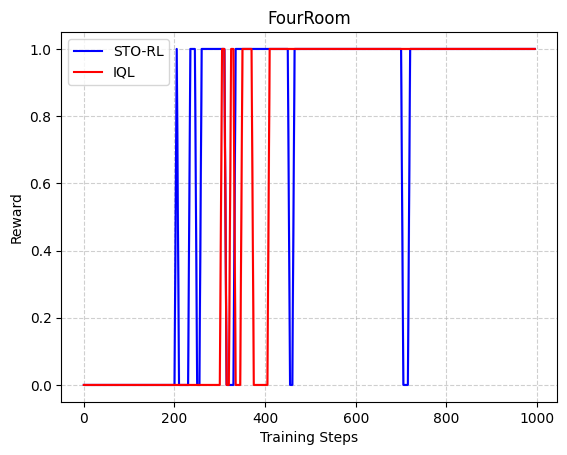

In [52]:
# x-axis (e.g., training steps or episodes)
x = np.arange(len(reward_list_sto)) * 5

# Plot mean reward curve
plt.plot(x, reward_list_sto, label="STO-RL", color="blue")
# Plot std as shaded area
plt.fill_between(
    x,
    np.array(reward_list_sto) - np.array(std_list_sto),
    np.array(reward_list_sto) + np.array(std_list_sto),
    color="blue",
    alpha=0.2
)

# Plot mean reward curve
plt.plot(x, reward_list_iql, label="IQL", color="red")
# Plot std as shaded area
plt.fill_between(
    x,
    np.array(reward_list_iql) - np.array(std_list_iql),
    np.array(reward_list_iql) + np.array(std_list_iql),
    color="red",
    alpha=0.2
)

plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("FourRoom")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Eval

In [14]:
# Evaluation
def evaluate_policy(state_dim):
  state, _ = env.reset()
  total_reward = 0
  done = False
  step = 0
  while not done:
    state_tensor = torch.FloatTensor(state_to_tensor(state, state_dim=state_dim)).to(device)
    action = iql.policy_network(state_tensor).argmax().item()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward
    step +=1

    if step >= max_steps:
      break


  return total_reward, step

In [ ]:
eval_rewards = []
eval_length = []
for _ in range(100):
  r, l = evaluate_policy(state_dim=state_dim)
  eval_rewards.append(r)
  eval_length.append(l)

eval_rewards = np.array(eval_rewards)
eval_length = np.array(eval_length)
print(f"Average evaluation reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
print(f"Average evaluation length: {np.mean(eval_length):.2f} ± {np.std(eval_length):.2f}")

Average evaluation reward: 1.00 ± 0.00
Average evaluation length: 20.00 ± 0.00


In [ ]:
state, _ = env.reset()
total_reward = 0
done = False
step = 0
while not done:
  state_tensor = torch.FloatTensor(state_to_tensor(state, state_dim=state_dim)).to(device)
  action = iql.q_network(state_tensor).argmax().item()
  print(f"Step: {step}")
  print(f"State: {state}")
  print(f"Action: {action}")


  state, reward, terminated, truncated, _ = env.step(action)
  done = terminated or truncated
  total_reward += reward

  print(f"Reward: {total_reward}")
  print(f"Next_State: {state}")
  step +=1



  if step >= max_steps:
    break

Step: 0
State: 0
Action: 3
Reward: 0
Next_State: 1
Step: 1
State: 1
Action: 3
Reward: 0
Next_State: 2
Step: 2
State: 2
Action: 3
Reward: 0
Next_State: 3
Step: 3
State: 3
Action: 3
Reward: 0
Next_State: 4
Step: 4
State: 4
Action: 2
Reward: 0
Next_State: 3
Step: 5
State: 3
Action: 3
Reward: 0
Next_State: 4
Step: 6
State: 4
Action: 2
Reward: 0
Next_State: 3
Step: 7
State: 3
Action: 3
Reward: 0
Next_State: 4
Step: 8
State: 4
Action: 2
Reward: 0
Next_State: 3
Step: 9
State: 3
Action: 3
Reward: 0
Next_State: 4
Step: 10
State: 4
Action: 2
Reward: 0
Next_State: 3
Step: 11
State: 3
Action: 3
Reward: 0
Next_State: 4
Step: 12
State: 4
Action: 2
Reward: 0
Next_State: 3
Step: 13
State: 3
Action: 3
Reward: 0
Next_State: 4
Step: 14
State: 4
Action: 2
Reward: 0
Next_State: 3
Step: 15
State: 3
Action: 3
Reward: 0
Next_State: 4
Step: 16
State: 4
Action: 2
Reward: 0
Next_State: 3
Step: 17
State: 3
Action: 3
Reward: 0
Next_State: 4
Step: 18
State: 4
Action: 2
Reward: 0
Next_State: 3
Step: 19
State: 3
Acti

#